#### Stock prediction using linear regression in Scikit Learn and Tensorflow
http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html

In [1]:
import requests, math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split
import tensorflow as tf

In [2]:
URL = "https://www.quandl.com/api/v3/datatables/WIKI/PRICES.json?date.gte=20070101&date.lt=20170520&ticker=TSLA&api_key=ZaKyNB5-sxfx1XFYfFD_"

r = requests.get(URL)

if r.status_code ==200:
    TSLA = r.json()

    data_tsla_all = TSLA['datatable']['data']

    adj_open = list()
    adj_close = list()
    adj_high = list() 
    adj_low = list()
    adj_vol = list()

    for item in data_tsla_all:
        adj_open.append(item[9])
        adj_high.append(item[10])
        adj_low.append(item[11])
        adj_close.append(item[12])
        adj_vol.append(item[13])

        
adj_open = np.asarray(adj_open)
adj_high = np.asarray(adj_high)
adj_low = np.asarray(adj_low)
adj_close = np.asarray(adj_close)
HL_PSC = (adj_high-adj_low)/adj_high*100
OC_PSC = (adj_close-adj_open)/adj_open*100


In [3]:
all_data = pd.DataFrame({'close':adj_close,'HL_PSC':HL_PSC, 'OC_PSC': OC_PSC, 'vol': adj_vol, 'label':adj_close})

#### shifting closing values 10% up, so we can set the future values of the stcks as the label

In [4]:
all_data['label'] = all_data['label'].shift(-int(math.ceil(0.1*len(all_data['label']))))
all_data.dropna(inplace=True)

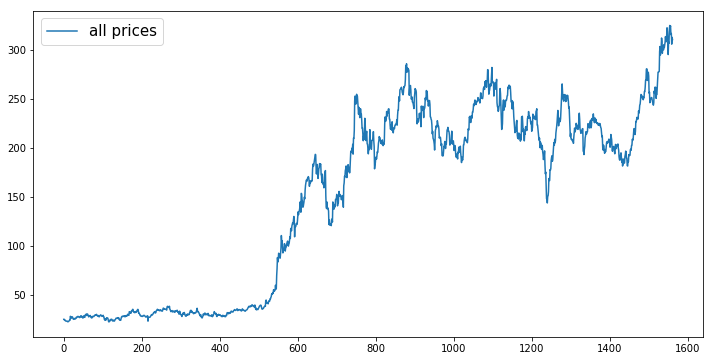

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(all_data['label'], label="all prices")
ax.legend(loc='upper left', fontsize=15)
plt.show()

In [11]:
X = np.array(all_data[['vol','OC_PSC','HL_PSC','close']])
y = np.array(all_data['label'])

# breaking data into training and testing sets

# breaking 1
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# breaking 2
rnd_indices = np.random.rand(len(X)) < 0.80
X_train = X[rnd_indices]
y_train = y[rnd_indices]
X_test = X[~rnd_indices]
y_test = y[~rnd_indices]

#### Scikit Learn Linear regression

In [13]:
cl = LinearRegression()
cl.fit(X_train, y_train)
accuracy = cl.score(X_test, y_test)
print("The accuracy of prediction is {}".format(accuracy))

# to see coefficients
#print(cl.coef_)

The accuracy of prediction is 0.7895076354104023


In [ ]:
# if you want to save classifier and load it later
import pickle
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

pickle_load = open('linearregression.pickle','rb')
clf = pickle.load(pickle_load)

#### comparing test values against predicted values, 79% accuracy

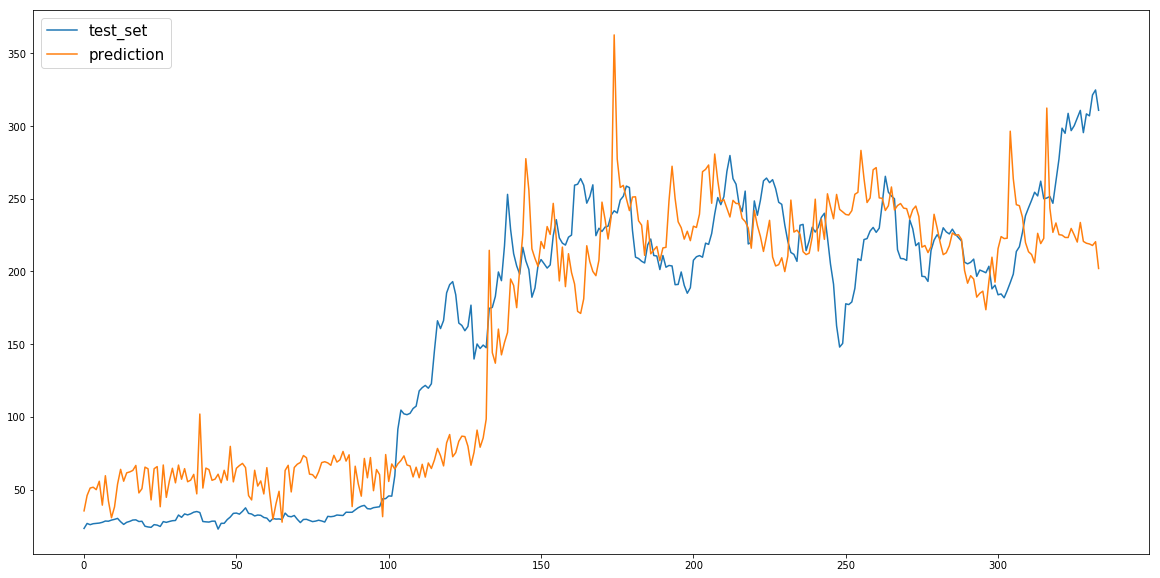

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_test, label="test_set")
ax.plot(cl.predict(X_test), label="prediction")
ax.legend(loc='upper left', fontsize=15)
plt.show()

#### Can we improve by normalizing features? eh! No

In [ ]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

X = np.array(all_data[['vol','OC_PSC','HL_PSC','close']])
y = np.array(all_data['label'])

X = feature_normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cl = LinearRegression()
cl.fit(X_train, y_train)
accuracy = cl.score(X_test, y_test)
print(accuracy)

### Tensorflow

In [15]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

# adding ones vector to the begining of the features vector (for b value in y =XW+b)
def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],(n_training_samples,n_dim + 1))
    l = np.reshape(labels,(n_training_samples,1))
    return f, l

In [16]:
X = feature_normalize(X)
X, y = append_bias_reshape(X,y)
n_dim = X.shape[1]

# breaking 2
rnd_indices = np.random.rand(len(X)) < 0.80
X_train = X[rnd_indices]
y_train = y[rnd_indices]
X_test = X[~rnd_indices]
y_test = y[~rnd_indices]

learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))

init = tf.global_variables_initializer()

In [17]:
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

The accuracy of prediction is 0.756912350654602


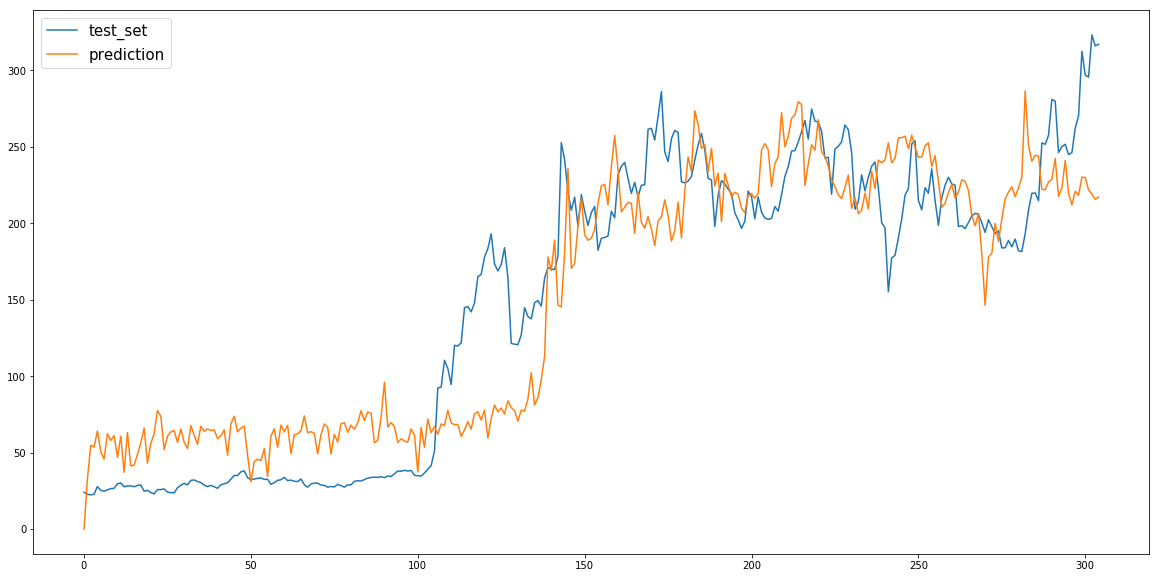

In [18]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        sess.run(training_step, feed_dict={X:X_train, Y:y_train})
        cost_history = np.append(cost_history,sess.run(cost,feed_dict={X:X_train, Y:y_train}))   
    
    u = tf.reduce_sum(tf.square(y_ - Y))
    v = tf.reduce_sum(tf.square(y_ - tf.reduce_mean(Y)))
    R2_value = 1 - u/v
    R2_value = sess.run(R2_value,feed_dict={X:X_test, Y:y_test})
    print("The accuracy of prediction is {}".format(R2_value))
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_test, label="test_set")
    y_plot = sess.run(y_,feed_dict={X:X_test})
    plt.plot(y_plot, label="prediction")
    ax.legend(loc='upper left', fontsize=15)
    plt.show()

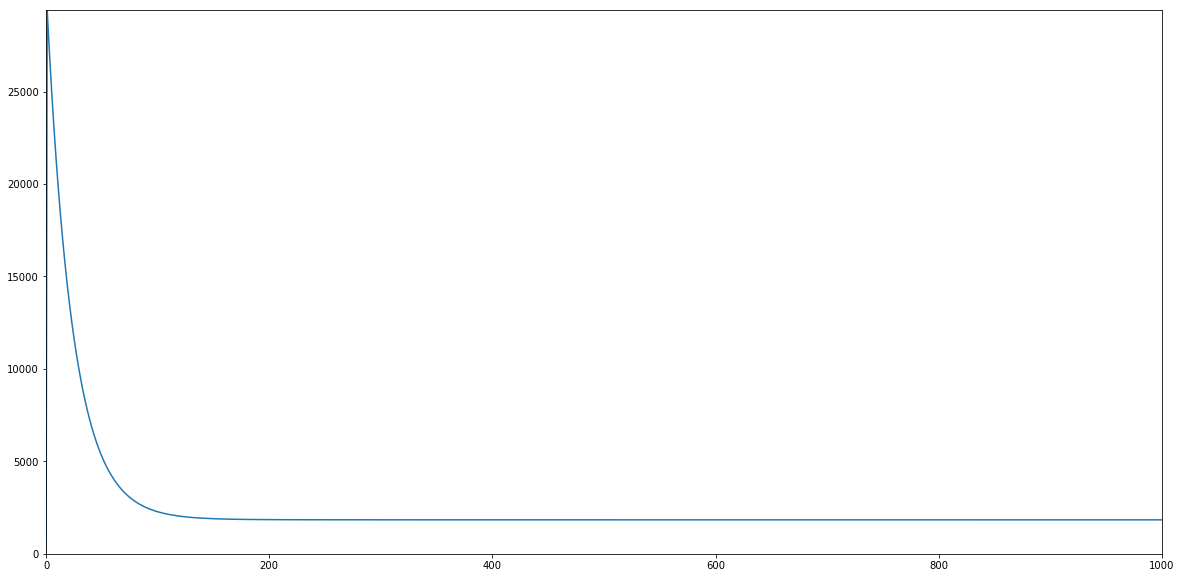

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(cost_history)), cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

### SVM
Takes too long! Aborted

In [ ]:
from sklearn import svm
cl2 = svm.SVR(kernel='linear')
cl2.fit(X_train, y_train)
